In [1]:
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
import numpy as np

#import solver related modules
from MCEq.core import MCEqRun
import mceq_config as config
#import primary model choices
import crflux.models as pm

In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model="DPMJET-III-19.1",
#primary cosmic ray flux model
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0
)

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [3]:
#Power of energy to scale the flux (the results will be returned as E**mag * flux)
mag = 0

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define a zenith angle, counted positively from vertical direction. Theta = 0. means vertical, theta = 90. horizontal
theta = 0.

In [10]:
print(mceq_run.e_bins)

len(mceq_run.e_bins)

egrid_new = np.geomspace(1e-1, 1e11, 121)
print(egrid_new)

[7.94328235e-02 1.00000000e-01 1.25892541e-01 1.58489319e-01
 1.99526231e-01 2.51188643e-01 3.16227766e-01 3.98107171e-01
 5.01187234e-01 6.30957344e-01 7.94328235e-01 1.00000000e+00
 1.25892541e+00 1.58489319e+00 1.99526231e+00 2.51188643e+00
 3.16227766e+00 3.98107171e+00 5.01187234e+00 6.30957344e+00
 7.94328235e+00 1.00000000e+01 1.25892541e+01 1.58489319e+01
 1.99526231e+01 2.51188643e+01 3.16227766e+01 3.98107171e+01
 5.01187234e+01 6.30957344e+01 7.94328235e+01 1.00000000e+02
 1.25892541e+02 1.58489319e+02 1.99526231e+02 2.51188643e+02
 3.16227766e+02 3.98107171e+02 5.01187234e+02 6.30957344e+02
 7.94328235e+02 1.00000000e+03 1.25892541e+03 1.58489319e+03
 1.99526231e+03 2.51188643e+03 3.16227766e+03 3.98107171e+03
 5.01187234e+03 6.30957344e+03 7.94328235e+03 1.00000000e+04
 1.25892541e+04 1.58489319e+04 1.99526231e+04 2.51188643e+04
 3.16227766e+04 3.98107171e+04 5.01187234e+04 6.30957344e+04
 7.94328235e+04 1.00000000e+05 1.25892541e+05 1.58489319e+05
 1.99526231e+05 2.511886

In [13]:
#Set the zenith angle
mceq_run.set_theta_deg(theta)
n_pts = 100
X_grid = np.linspace(0.1, mceq_run.density_model.max_X, n_pts)
mceq_run.set_single_primary_particle(1e9, pdg_id = 2212)
mceq_run.solve(int_grid=X_grid)

In [15]:
print(len(X_grid))

100


In [5]:
longitudinal_spectrum = []
for idx in range(n_pts):
    # print('Reading solution at X = {0:5.2f} g/cm2'.format(X_grid[idx]))
    longitudinal_spectrum.append(mceq_run.get_solution('mu+', grid_idx=idx))

0.03546885080299145 0.03546763853954276 0.03546885080258866 0.03544865024439287 (0.035468225206877306, 1.359862369203291e-08)


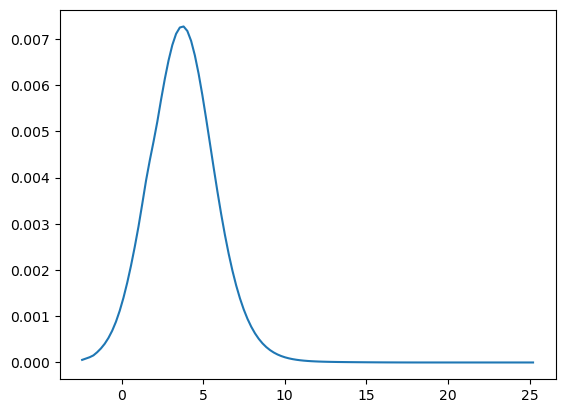

In [14]:
# Test different variants of intergration
from scipy import integrate, interpolate




# np.where(longitudinal_spectrum[0] > 1e-17, longitudinal_spectrum[0] , 0)
pos = np.where(longitudinal_spectrum[0] > 1e-23, longitudinal_spectrum[0] , 0)
I1 = integrate.simpson(pos*e_grid, np.log(e_grid))
I2 = integrate.trapezoid(pos*e_grid, np.log(e_grid))
I3 = integrate.simpson(longitudinal_spectrum[0]*e_grid, np.log(e_grid))
I4 = integrate.simpson(longitudinal_spectrum[0], e_grid)

fx = interpolate.interp1d(np.log(e_grid), longitudinal_spectrum[0]*e_grid, kind='cubic')

I5 = integrate.quad(fx, np.log(e_grid[0]), np.log(e_grid[-1]))


print(I1, I2, I3, I4, I5)

plt.plot(np.log(e_grid), pos*e_grid)
# plt.loglog(e_grid, longitudinal_spectrum[0])
# e_grid
# len(longitudinal_spectrum[0])
# longitudinal_spectrum[0]
# res = np.where(longitudinal_spectrum[0] > 1e-23, longitudinal_spectrum[0] , 0)

In [25]:
# Populate longitudinal spectra for all particles:
part_long_spectra = {}
for p in mceq_run.pman.all_particles:
    longitudinal_spectrum = []
    for idx in range(n_pts):
        longitudinal_spectrum.append(mceq_run.get_solution(p.name, grid_idx=idx))
    
    part_long_spectra[p.name] = (p, longitudinal_spectrum)

In [28]:
part_long_mult = {}
for pname, (pobj, long_spec) in part_long_spectra.items():
    res_mult = []
    for i, spec in enumerate(long_spec):
        res_mult.append(integrate.simpson(spec*e_grid, np.log(e_grid)))
        
    part_long_mult[pname] = (part_long_spectra[pname][0], res_mult)

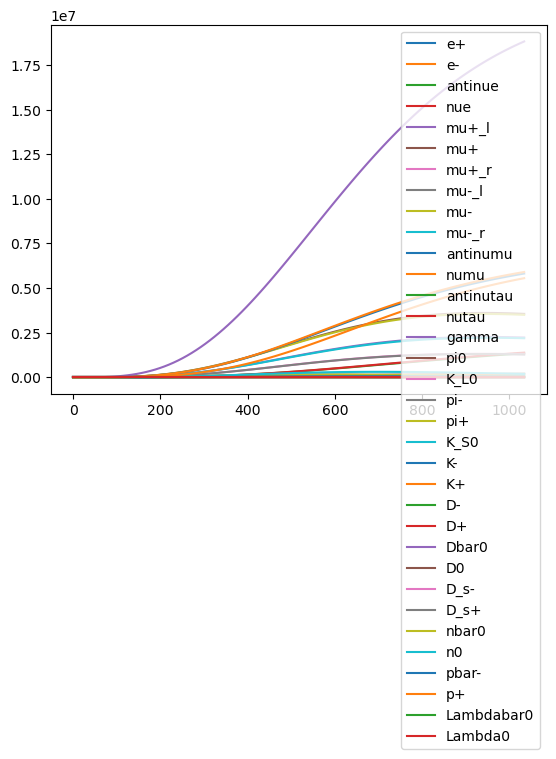

In [30]:

for pname, (pobj, res_mult) in part_long_mult.items():
    plt.plot(X_grid, res_mult, label = pname)
    
plt.legend()    

In [16]:
# for p in mceq_run.pman.all_particles:
#     print(p.name, p.mass)

In [24]:
xdepth_grid_bins = np.linspace(0.1, 1012, 100)
xdepth_grid_centers = (xdepth_grid_bins[0:-1] + xdepth_grid_bins[1:])/2
xdepth_grid_steps = xdepth_grid_bins[1:] - xdepth_grid_bins[0:-1]
print(xdepth_grid_bins[0:5], xdepth_grid_centers[0:5], xdepth_grid_steps[0:5])

[ 0.1        10.32121212 20.54242424 30.76363636 40.98484848] [ 5.21060606 15.43181818 25.6530303  35.87424242 46.09545455] [10.22121212 10.22121212 10.22121212 10.22121212 10.22121212]
